In [58]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC

In [59]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [60]:
plt.style.use('science')
sns.set_theme()

plt.rcParams['figure.figsize'] = (8, 4)

Сформируем случайную двумерную область точек для изучения одного из методов понижение размерности - метод главных компонент (PCA).

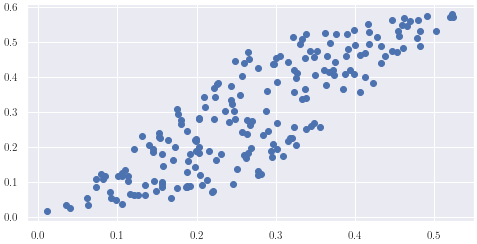

In [61]:
rng = np.random.default_rng(665)
X = np.dot(rng.random((2, 2)), rng.random((2, 200))).T
plt.scatter(X[:, 0], X[:, 1]);

Текущая размерность выборки (набора признаков) `2`. С помощью PCA можем понизить ее до `1`:

In [62]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)
print(f'before PCA: {X.shape}')
print(f'after PCA: {X_pca.shape}')

before PCA: (200, 2)
after PCA: (200, 1)


В простом смысле, после использования PCA мы получили новый набор признаков (признаки в котором эвристически не связаны с начальными признаками, т.е. просто числа), который максимально близок исходному набору по величине энтропии. При этом количество признаков в полученном наборе меньше чем в исходном на размерность (было `200 * 2 = 400`, стало `200 * 1 = 200`).

С помощью метода `inverse_transform` и полученных после трансформации признаков мы можем восстановить исходный набор:

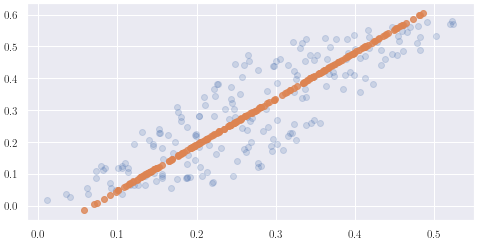

In [63]:
X_ = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_[:, 0], X_[:, 1], alpha=0.8);

Не без потери информации, конечно.

_Кстати, по графику наглядно виден принцип работы PCA для двумерного пространства - вычисляется (путем минимизации метрики дистанции \[например, евклтдово расстояние\]) первая главная компонента (гиперплоскость, линия) вдоль максимальной выборочной дисперсии, затем сроится вектор его нормали, максимально описывающий оставшуюся дисперсию_

Теперь применим PCA в боевых условиях - на наборе одноканальных картинок размера 8x8 рукописных цифр.

In [64]:
X, y = datasets.load_digits(return_X_y=True)
X.shape, y.shape

((1797, 64), (1797,))

С помощью PCA с количеством главных компонент `2` мы превратим плоский массив пикселей, каждого изображения, в 2 оторванных от реальности числа, вобравших в себя большую (наверное) долю информации с картинок.

In [65]:
pca_2 = PCA(n_components=2)
X_2 = pca_2.fit_transform(X)

Полученные 2 числа можно интерпретировать как координаты точки в двумерном пространстве.

Таким образом мы придем к первому приложению - визуализация сложных, многомерных данных:

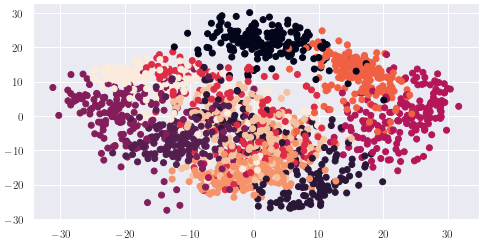

In [66]:
plt.scatter(X_2[:, 0], X_2[:, 1], c=y);

По графику видно (если знать это заранее), PCA, действительно, вместил в два числа много информации - мы видим (если знать это заранее) почти 10 кластеров точек, соответствующих 10 числам.

Можно исследовать зависимости доли объясняемой дисперсии каждой компонентой и ее накопленной суммы в зависимости от количества компонент. Атрибут модели `explained_variance_ratio_` (т.к. PCA является итеративным методом) - массив, содержащий доли объясненной дисперсии каждой компонентой.

In [67]:
pca_64 = PCA(n_components=64)
X_64 = pca_64.fit_transform(X)

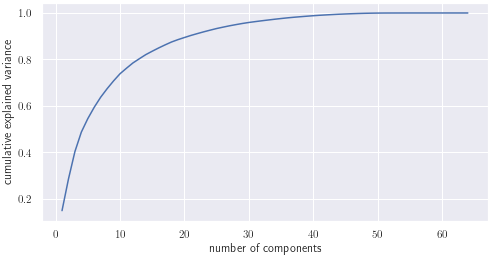

In [68]:
plt.plot(np.arange(1, len(pca_64.explained_variance_ratio_) + 1), np.cumsum(pca_64.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

После 30 компонент доля объясняемой дисперсии каждой следующей компонентой является достаточно низкой.
А после 40 компонент рост накопленной доли объясняемой дисперсии практически не заметен.

Еще одна возможность применения PCA - удаление шумов. Стараясь сохранить как можно больше полезной информации и при этом уменьшить количество признаков, PCA отбрасывает большую долю незначимых, "зашумляющие" признаков.

_По выше приведенным причинам, PCA также помогает справиться с мультиколлинеарностью_

In [69]:
from mpl_toolkits.axes_grid1 import ImageGrid


def plot_digits(data):
    fig = plt.figure(figsize=(12, 5))
    grid = ImageGrid(fig, 111, (4, 10))
    for x, ax in zip(data, grid):
        ax.imshow(x.reshape(8, 8), cmap='binary', interpolation='nearest', clim=(0, 16))
        ax.grid(False)


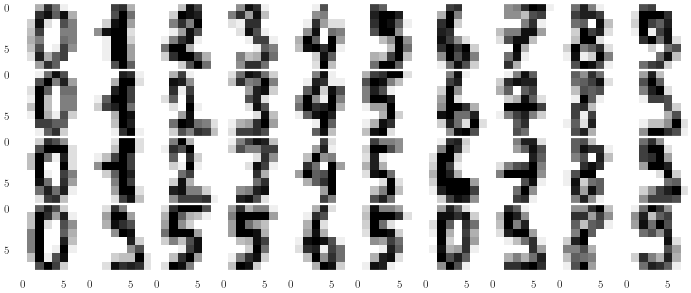

In [70]:
plot_digits(X)

С помощью нормального распределения добавим немного шума, чтобы потом победить его:

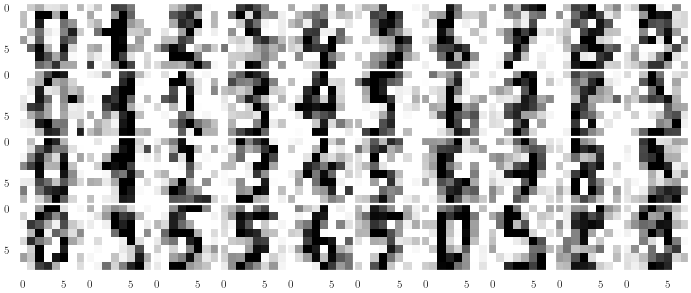

In [71]:
X_ = rng.normal(X, 4)
plot_digits(X_)

В случаях борьбы с шумом обычно требуется сохранить 50-80% имеющейся информации.
В задании требуется найти минимальное количество компонент для сохранения 50%:

In [72]:
pca_20 = PCA(n_components=20)
X_20_ = pca_20.fit_transform(X_)

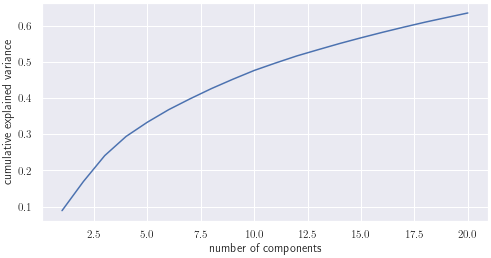

In [73]:
plt.plot(np.arange(1, len(pca_20.explained_variance_ratio_) + 1), np.cumsum(pca_20.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [74]:
n = 12
np.cumsum(pca_20.explained_variance_ratio_)[n - 1]

0.5161372991061279

In [75]:
pca_12 = PCA(n_components=n)
X_12_ = pca_12.fit_transform(X_)

После применения PCA качество изображений значительно улучшилось по сравнению с зашумленными:

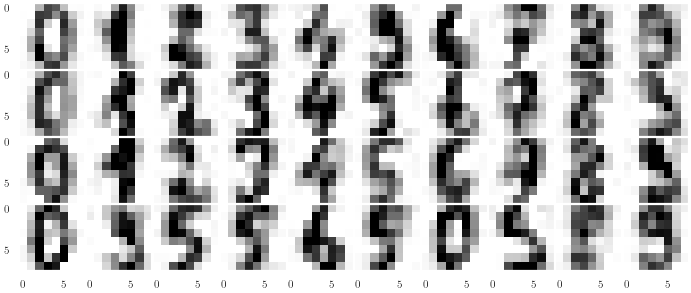

In [76]:
X_pca_ = pca_12.inverse_transform(X_12_)
plot_digits(X_pca_)

**Вывод 1:** рассмотренные модели PCA отлично справились со своими задачами - визуализация данных, удаление шумов.

Еще методы понижения размерности часто применяются в задачах классификации изображений, для уменьшения количества параметров подаваемых в классификаторов. Не все классификаторы могут работать с большим числом независимых переменных, некоторые оказываются довольно медленными, а изображения, даже меленькие содержат большое количество признаков (например, трехцветная картинка размером 80x80 раскладывается в `80 * 80 * 3 = 19200` параметров). Здесь на помощь приходит PCA.

_Усложним задачу, взяв зашумленный набор данных_

In [77]:
pipeline = Pipeline([
    ('pca', PCA(n_components=15)),
    ('clf', SVC(max_iter=1000)),
])

param_grid = [{
    'pca': [
        None,
        *[PCA(n_components=i, random_state=0) for i in np.arange(15, 50, 4)]
    ],
    'clf': [
        SVC(max_iter=1000, random_state=0),
        LinearSVC(max_iter=1000, random_state=0),
    ]
}]

search = GridSearchCV(
    pipeline,
    param_grid,
    cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    verbose=4,
    n_jobs=4,
)

In [78]:
if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        search.fit(X_, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [79]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_score')[[
    'param_pca',
    'param_clf',
    'mean_test_score',
    'mean_score_time',
    'mean_fit_time',
]]

,param_pca,param_clf,mean_test_score,mean_score_time,mean_fit_time
6,"PCA(n_components=35, random_state=0)","SVC(max_iter=1000, random_state=0)",0.945556,0.056795,0.114699
4,"PCA(n_components=27, random_state=0)","SVC(max_iter=1000, random_state=0)",0.945000,0.055776,0.102491
7,"PCA(n_components=39, random_state=0)","SVC(max_iter=1000, random_state=0)",0.942778,0.065433,0.140629
8,"PCA(n_components=43, random_state=0)","SVC(max_iter=1000, random_state=0)",0.942222,0.068646,0.147026
3,"PCA(n_components=23, random_state=0)","SVC(max_iter=1000, random_state=0)",0.941111,0.047722,0.083994
9,"PCA(n_components=47, random_state=0)","SVC(max_iter=1000, random_state=0)",0.939444,0.061720,0.146653
1,"PCA(n_components=15, random_state=0)","SVC(max_iter=1000, random_state=0)",0.937778,0.040145,0.066563
2,"PCA(n_components=19, random_state=0)","SVC(max_iter=1000, random_state=0)",0.937778,0.040408,0.065676
5,"PCA(n_components=31, random_state=0)","SVC(max_iter=1000, random_state=0)",0.937222,0.057087,0.108253
0,None,"SVC(max_iter=1000, random_state=0)",0.935000,0.059991,0.100978


За счет удаления шумов, модели с применением PCA значительно превосходят в точности пайплайны одиноких классификаторов:
- `0.946` против `0.935` для SVM с ядром `rbf` (радиальной базисной функции) \[ну тут со "значительно" я погорячился\]
- `0.84` против `0.77` для SVM с линейным ядром `libsvm` реализации (а здесь прирост действительно ощутимый)

Однако производительность (время классификации) моделей после уменьшения признаков особо не увеличилась, а для большого числа компонент даже деградировала. Это связано не такой большой разницей в количестве признаков после уменьшения (изначально из 64), но с появлением дополнительных накладных расходов на вычисления в PCA. Однако для больших изображений результат должен быть лучше.

_Спорно, но модели с 15-ю компонентами можно рассматривать к применению_

**Вывод 2:** PCA - это хорошо, но не ✨